In [59]:
#Import two moons
from sklearn.datasets import make_moons
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math


In [60]:
def time_horizon(epsilon=0.002, T=80, rho=7, N=18, device='cpu'):
    """
    Compute the value of t following the formula at the bottom left page 4 of the paper.
    The horizon is flipped compared to the paper because we want to start with the largest value of t.
    epsilon is the minmum std of the noise
    T is the maximum std of the noise
    N is the number of steps
    """
    return torch.tensor([(T ** (1/rho) + (i-1)/(N-1) * (epsilon**(1/rho) - T**(1/rho)))**rho for i in range(1, N+1)]).to(device).type(torch.float32)

class MoonsDataset(Dataset):
    def __init__(self, n_samples, device, noise=0.05):
        X, _ = make_moons(n_samples=n_samples, noise=noise)
        X = torch.tensor(X, dtype=torch.float32)
        self.X = X.to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_whole_dataset(self):
        return self.X

class DiffusionModel(torch.nn.Module):
    def __init__(self, dim, device, n_layers=3, n_units=256):
        super().__init__()
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    def time_embedding(self, t, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of times (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = t[:, None] / max_period  ** (2 * torch.arange(half_dim, device=self.device) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
        
        
    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y += time_embed # Add the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)
    
def sampling_loop(model, device, batch_size=64, epsilon=0.002, T=80, rho=7, N=18):
    """
    Sample a gaussian noise and iteratively denoise it using the diffusion model.
    """
    x_evolution = [] # List to store the evolution of the denoising process

    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon

    x_next = torch.randn(batch_size, 2, device=device) * Ts[0] # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_evolution.append(x_next.detach().cpu().clone()) # Append the initial latents to the list

    # Denoising loop following a simple Euler scheme
    for _, (t_cur, t_next) in list(enumerate(zip(Ts[:-1], Ts[1:]))):
        x_cur = x_next # Set the current x to the previous x
        batched_t = torch.full((batch_size,), t_cur, dtype=torch.long, device=device) # Create a batched time index
        predicted_x_0_from_x_t = model(x_cur, batched_t) # Predict the denoised image using the model. The time is passed through the index
        euler_step_direction = (predicted_x_0_from_x_t - x_cur) / t_cur # Compute the direction of the Euler step
        x_next = x_cur + (t_cur - t_next) * euler_step_direction # Take an euler step of length t_next - t_cur in the direction euler_step_direction
        
        x_evolution.append(x_next.detach().cpu().clone()) #Append a copy of x_next that is sent to the cpu deatched etc 

    return x_evolution

def training_loop(model, optimizer, dataloader, device, n_epochs=500, epsilon=0.002, T=80, rho=7, N=18):
    """
    Training loop for the diffusion model
    """
    batch_size = dataloader.batch_size # Get the batch size of the dataloader
    Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon
    losses = [] # List to store the losses

    for epoch in range(n_epochs):
        running_loss = 0.0 # Initialize the running loss
        for X in dataloader:
            optimizer.zero_grad() # Zero the gradients

            timesteps = torch.randint(0, len(Ts), (batch_size,)) # Sample random time steps
            t = Ts[timesteps].to(device) # Get the time corresponding to the time steps
            
            X_noisy = X + torch.randn_like(X) * t[:, None] # Add time-scaled noise to the data
            
            X_hat = model(X_noisy, t) # Predict the denoised image using the model. The time is passed through the index
           
            loss = torch.nn.functional.mse_loss(X_hat, X) # Compute the loss
            loss.backward() # Backward pass
            optimizer.step() # Optimize the model

            running_loss += loss.item() # Add the loss to the running loss
        losses.append(running_loss / len(dataloader)) # Append the average loss to the losses list
        if (epoch+1) % 25 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {losses[-1]:.4f}") # Print the average loss

        
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)")
    plt.show()

    return losses

In [68]:
def N_scheduled(k, K, s0=2, s1=150):
    """
    Compute the value of N following the formula p26
    k is the current step
    K is the total number of steps
    """
    return math.ceil((k / K * ((s1 + 1)**2 - s0**2))**0.5 + s0**2 - 1) + 1



class ConsistencyModel(torch.nn.Module):
    def __init__(self, dim, device, epsilon=0.002, sigma_data=0.5, n_layers=3, n_units=256):
        super().__init__()
        self.epsilon = epsilon
        self.sigma_data = sigma_data
        self.dim = dim
        self.device = device
        self.n_layers = n_layers
        self.n_units = n_units
        self.linear1 = torch.nn.Sequential(torch.nn.Linear(dim, n_units).to(device), torch.nn.GELU())
        self.layers = torch.nn.ModuleList([torch.nn.Sequential(torch.nn.Linear(n_units, n_units).to(device), torch.nn.GELU()) for _ in range(n_layers)])
        self.final_layer = torch.nn.Linear(n_units, dim).to(device)

    def c_out(self, t):
        return (self.sigma_data * (t - self.epsilon) / (self.sigma_data ** 2 + t **2) ** 0.5)[:, None]
    
    def c_skip(self, t):
        return (self.sigma_data ** 2 / ((t - self.epsilon) ** 2 + self.sigma_data ** 2))[:, None]


    def time_embedding(self, t, dim, max_period=10000):
        """
        Compute the time embedding
        timesteps: a batch of times (1D tensor)
        dim: the dimension of the embedding
        """
        half_dim = dim // 2
        freqs = t[:, None] / max_period  ** (2 * torch.arange(half_dim, device=self.device) / dim)
        return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=1).to(self.device)
    
    def F(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        """
        time_embed = self.time_embedding(t, self.n_units).to(self.device) # Compute the time embedding
        y = self.linear1(x) # Apply the first linear layer which differs from the other layers
        
        # Apply the layers
        for layer in self.layers:
            y += time_embed # Add the time embedding to the input
            y = layer(y) # Apply the layer
        return self.final_layer(y)

    def forward(self, x, t):
        """
        Forward pass
        x: input tensor
        t: current time step index
        The formula is from the right column of p3 of the original paper. 
        """
        return self.c_skip(t) * x + self.c_out(t) * self.F(x, t)
   

def consistency_training_loop(model, optimizer, dataloader, device, n_epochs=2000, epsilon=0.002, T=80, rho=7):
    batch_size = dataloader.batch_size
    dataset_size = len(dataloader.dataset)
    training_iterations = n_epochs * (dataset_size // batch_size)
    k = 0
    losses = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        for X in dataloader:
            optimizer.zero_grad() # Zero the gradients
            N = N_scheduled(k, training_iterations) # Follow the schedule to compute N
            Ts = time_horizon(epsilon, T, rho, N, device) # Compute the time horizon for the current N
            n = torch.randint(0, N - 1, (batch_size,)) # Sample random time steps in the current time horizon
            z = torch.randn_like(X) # Sample random noise latents
            loss = torch.nn.functional.mse_loss(model(X + z * Ts[n][:, None], Ts[n]), model(X + z * Ts[n+1][:, None], Ts[n+1])) # Compute the loss following eq10 in the paper
            loss.backward() # Backward pass
            optimizer.step() # Optimize the model
            running_loss += loss.item() # Add the loss to the running loss
            k += 1 # Increment k as done in Algorithm 3 of the paper
        if (epoch+1) % 25 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss / len(dataloader):.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)")
    plt.show()

def consistency_sampling(model, device, batch_size=64, T=80):
    """
    Sample a gaussian noise and denoise it in a single step using the consistency model.
    """
    x_evolution = [] # List to store the evolution of the denoising process
    z = torch.randn(batch_size, 2, device=device) * T # Sample the latents by sampling a batch of gaussian noise with the maximum std
    x_evolution.append(z.detach().cpu().clone()) # Append the initial latents to the list
    batched_T = torch.full((batch_size,), T, dtype=torch.long, device=device) # Create a batched time index
    denoised_x = model(z, batched_T) # Denoise the latents using the consistency model
    x_evolution.append(denoised_x.detach().cpu().clone()) # Append the denoised latents to the list
    return x_evolution



In [62]:
dataset_size = 16384
training_batch_size = 1024
n_epochs = 2000
epsilon = 0.002
T = 80
rho = 7
n_units = 128
n_layers = 3
dim = 2
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

Epoch 25/2000 - Loss: 0.0035
Epoch 50/2000 - Loss: 0.0017
Epoch 75/2000 - Loss: 0.0011
Epoch 100/2000 - Loss: 0.0009
Epoch 125/2000 - Loss: 0.0007
Epoch 150/2000 - Loss: 0.0006
Epoch 175/2000 - Loss: 0.0005
Epoch 200/2000 - Loss: 0.0004
Epoch 225/2000 - Loss: 0.0004
Epoch 250/2000 - Loss: 0.0003
Epoch 275/2000 - Loss: 0.0003
Epoch 300/2000 - Loss: 0.0003
Epoch 325/2000 - Loss: 0.0003
Epoch 350/2000 - Loss: 0.0002
Epoch 375/2000 - Loss: 0.0002
Epoch 400/2000 - Loss: 0.0002
Epoch 425/2000 - Loss: 0.0002
Epoch 450/2000 - Loss: 0.0002
Epoch 475/2000 - Loss: 0.0002
Epoch 500/2000 - Loss: 0.0002
Epoch 525/2000 - Loss: 0.0002
Epoch 550/2000 - Loss: 0.0001
Epoch 575/2000 - Loss: 0.0001
Epoch 600/2000 - Loss: 0.0001
Epoch 625/2000 - Loss: 0.0001
Epoch 650/2000 - Loss: 0.0001
Epoch 675/2000 - Loss: 0.0001
Epoch 700/2000 - Loss: 0.0001
Epoch 725/2000 - Loss: 0.0001
Epoch 750/2000 - Loss: 0.0001
Epoch 775/2000 - Loss: 0.0001
Epoch 800/2000 - Loss: 0.0001
Epoch 825/2000 - Loss: 0.0001
Epoch 850/200

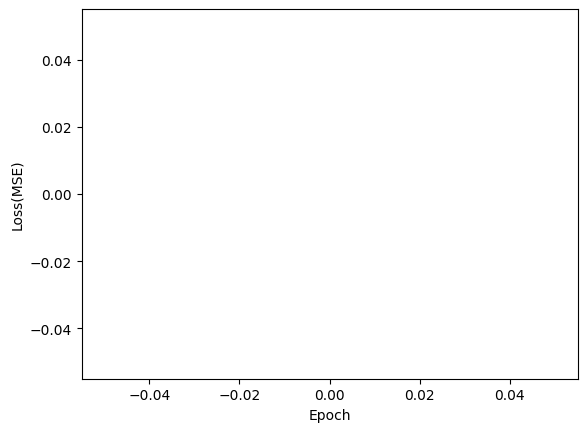

In [63]:
# Create the dataset
dataset = MoonsDataset(dataset_size, device)
dataloader = DataLoader(dataset, batch_size=training_batch_size, shuffle=True)

# Create the model
model = ConsistencyModel(dim, device, epsilon=epsilon, n_units=n_units, n_layers=n_layers).to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = consistency_training_loop(model, optimizer, dataloader, device, n_epochs=n_epochs, epsilon=epsilon, T=T, rho=rho)

In [71]:
x_evolution = consistency_sampling(model, device, batch_size=1024, T=T)

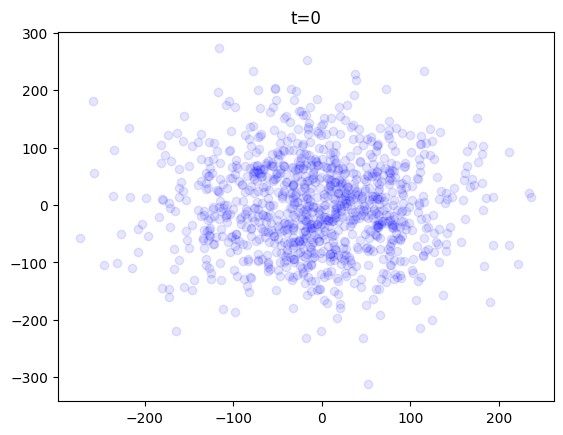

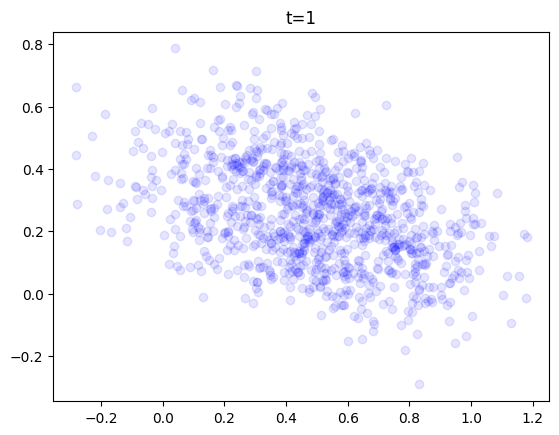

In [72]:
for i in range(len(x_evolution)):
    for X in x_evolution[i]:
        plt.scatter(X[0], X[1], c='b', alpha=0.1)
    plt.title(f"t={i}")
    plt.show()
    